# Main notebook
This notebook is able to reproduce all experiments and plots described in the reproducibility paper.

### Summary:
* ##### [Reproducing models and data for main claims.](#Reproducing-models-and-data-for-main-claims)
* ##### [Reproducing models and data for visualization.](#Reproducing-models-and-data-for-visualization)
* ##### [Reproducing original plots.](#Reproducing-original-plots)
* ##### [Additional visualization.](#Additional-visualization)

In [9]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export

%load_ext autoreload
device = "cuda" if torch.cuda.is_available() else "cpu"
IFLOW_FOLDER = 'iFlow_experiment'
IVAE_FOLDER = 'iVAE_experiment'
IVAE_FIXED_FOLDER = 'fixed-iVAE_experiment'
iFlow_vis_folder = 'visualization_' + IFLOW_FOLDER
iVAE_vis_folder = 'visualization_' + IVAE_FOLDER 
NUMBER_OF_SEEDS_MAIN = 100
NUMBER_OF_SEEDS_VISUALIZATION = 100


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reproducing models and data for main claims
In the cell below the hyperparameters from theh iFlow paper are used to reproduce the original results. For accurate reproduction you need to run it on a gpu, since the cpu you will get different results.  

For information about other paramaters consult the main.py in the iFlow folder by excuting `!python iFlow/main.py -h` in a code cell.

In [ ]:
cuda_flag = '-c' if device == "cuda" else ""

for i in range(1, NUMBER_OF_SEEDS_MAIN + 1):
    command_line = '1000_40_5_5_3_{seed}_gauss_xtanh_u_f'.format(seed=i)
    !python 'main.py' \
            '-x' {command_line}\
            '-i' 'iFlow' '-ft' 'RQNSF_AG' \
            '-npa' 'Softplus' \
            '-fl' '10' \
            '-lr_df' '0.25' \
            '-lr_pn' '10' \
            '-b' '64' \
            '-e' '20' \
            '-l' '1e-3' \
            '-exp' {IFLOW_FOLDER} \
            {cuda_flag} \
            '-s' '1' 

for i in range(1, NUMBER_OF_SEEDS_MAIN + 1):
    command_line = '1000_40_5_5_3_{seed}_gauss_xtanh_u_f'.format(seed=i)
    !python 'main.py' \
            '-x' {command_line}\
            '-i' 'iVAE' \
            '-lr_df' '0.25' \
            '-lr_pn' '10' \
            '-b' '64' \
            '-e' '20' \
            '-l' '1e-3' \
            '-g' '50' \
            '-d' '3' \
            '-exp' {IVAE_FOLDER} \
            {cuda_flag} \
            '-s' '1' 


# Reproducing models and data for visualization
In the cell below the data and models are produced used for the visualiation of the latent dimensions. This means that data and the latent dimension are both 2 instead of 5 as this enables us to plot on a 2D graph.

In [ ]:
cuda_flag = '-c' if device == "cuda" else ""

for i in range(1, NUMBER_OF_SEEDS_VISUALIZATION + 1):
    command_line = '1000_5_2_2_3_{seed}_gauss_xtanh_u_f'.format(seed=i)
    !python 'main.py' \
            '-x' {command_line}\
            '-i' 'iFlow' '-ft' 'RQNSF_AG' \
            '-npa' 'Softplus' \
            '-fl' '10' \
            '-lr_df' '0.25' \
            '-lr_pn' '10' \
            '-b' '64' \
            '-e' '20' \
            '-l' '1e-3' \
            '-exp' {iFlow_vis_folder} \
            {cuda_flag} \
            '-s' '1' 

for i in range(1, NUMBER_OF_SEEDS_VISUALIZATION + 1):
    command_line = '1000_5_2_2_3_{seed}_gauss_xtanh_u_f'.format(seed=i)
    !python 'main.py' \
            '-x' {command_line}\
            '-i' 'iVAE' '-ft' 'RQNSF_AG' \
            '-lr_df' '0.25' \
            '-lr_pn' '10' \
            '-b' '64' \
            '-e' '20' \
            '-l' '1e-3' \
            '-g' '50' \
            '-d' '3' \
            '-exp' {iVAE_vis_folder} \
            {cuda_flag} \
            '-s' '1' 

# Reproducing original plots


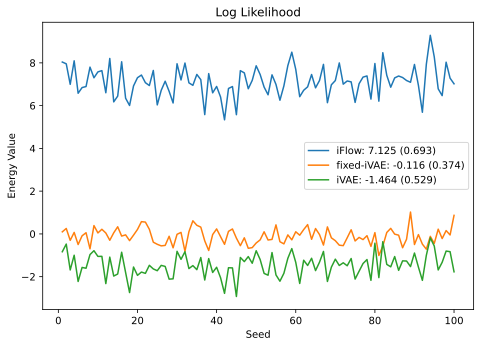

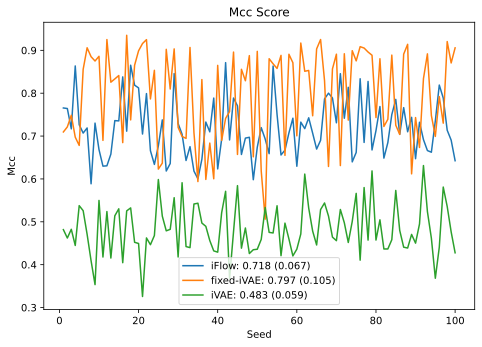

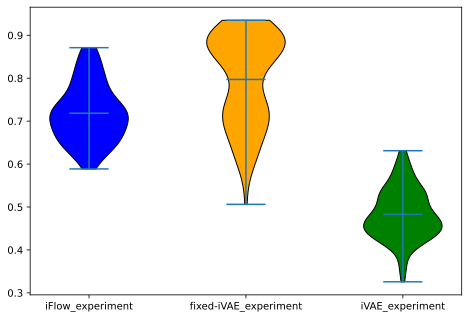

In [34]:
from plots import plot_attribute, Experiment_folder
%autoreload

# folder_paths = [IFLOW_FOLDER, IVAE_FOLDER]
folder_paths = [IFLOW_FOLDER, IVAE_FIXED_FOLDER, IVAE_FOLDER]
experiments = [Experiment_folder(path, device) for path in folder_paths]
ax, data = plot_attribute(experiments, "final_loss")
ax.set_title("Log Likelihood")
ax.set_xlabel("Seed")
ax.set_ylabel("Energy Value")
plt.savefig('Log Likelihood.png', bbox_inches='tight')
plt.show()

mcc_ax, data = plot_attribute(experiments, "final_performance")
mcc_ax.set_title("Mcc Score")
mcc_ax.set_xlabel("Seed")
mcc_ax.set_ylabel("Mcc")
plt.savefig('Mcc Score.png', bbox_inches='tight')
plt.show()



fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

colors = ("blue", "orange" , "green")

parts = ax.violinplot(data[1], positions=None, vert=True, widths=0.5, showmeans=True, showextrema=True, showmedians=False, quantiles=None, points=100)
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(1)

    
ax.set_xticks(np.arange(1, len(folder_paths) + 1))
ax.set_xticklabels(folder_paths)
    
plt.savefig("violin plot.png", bbox_inches='tight')

In [14]:
from plots import plot_latent_correlation
%autoreload

def get_best_model_pairs(iFlow_vis_folder, iVAE_vis_folder):
    iFlow_vis_experiments = Experiment_folder(iFlow_vis_folder, device)
    iVAE_vis_experiments = Experiment_folder(iVAE_vis_folder, device)

    top_iFlow = iFlow_vis_experiments.get_ranked_list("final_performance")[-1]
    top_iVAE = iVAE_vis_experiments.get_ranked_list("final_performance")[-1]

    best_iFlow_model, best_iFlow_dset = iFlow_vis_experiments.get_model_from_path(top_iFlow[0])
    iVAE_model, _ = iVAE_vis_experiments.get_model_from_experiment(top_iFlow)

    best_iVAE_model, best_iVAE_dset = iFlow_vis_experiments.get_model_from_path(top_iVAE[0])
    iFlow_model, _ = iFlow_vis_experiments.get_model_from_experiment(top_iVAE)
    
    return (best_iFlow_dset, best_iFlow_model, iVAE_model), (best_iVAE_dset, best_iVAE_model, iFlow_model)

comparison_1, comparison_2 = get_best_model_pairs(IFLOW_FOLDER, IVAE_FOLDER)
plot_latent_correlation(comparison_1[0], comparison_1[1], 40, 453)
plot_latent_correlation(comparison_1[0], comparison_1[2], 40, 453)


plot_latent_correlation(comparison_2[0], comparison_2[1], 40, 17930)
plot_latent_correlation(comparison_2[0], comparison_2[2], 40, 17930)

data loaded on cpu


FileNotFoundError: [Errno 2] No such file or directory: 'data/42'

In [ ]:
from plots import create_2D_performance_plot
%autoreload
comparison_1, comparison_2 = get_best_model_pairs(iFlow_vis_folder, iVAE_vis_folder)


# create_2D_performance_plot(comparison_1[0], comparison_1[2], comparison_1[1])

# Additional visualization

In [ ]:
from plots import *
%autoreload

for experiment in experiments:
    experiment.get_final_attribute("dataset_difficulty")

mcc_ax = plot_attribute(experiments, "final_performance")
ax = plot_attribute(experiments, "dataset_difficulty", mcc_ax)
plt.show()